# Growing Conditional Neural Cellular Automata

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [61]:
import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils.image import get_emoji
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [3]:
seed = 42

channel_size = 32
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 64
learning_rate = 1e-3

emojis = "🐶🐱🐭🐹🐰🦊🐻🐼"
target_size = 40
target_padding = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

,,,,,,,

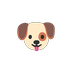
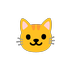
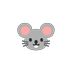
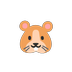
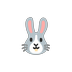
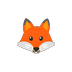
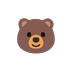
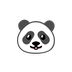

In [4]:
targets = jnp.array([get_emoji(emoji, size=target_size, padding=target_padding) for emoji in emojis])
targets_enc = jnp.eye(targets.shape[0])

mediapy.show_images(targets)

## Init state

In [5]:
def init_state(key):
	state_shape = targets.shape[1:3] + (channel_size,)

	state = jnp.zeros(state_shape)
	mid = tuple(size // 2 for size in state_shape[:-1])
	state = state.at[mid[0], mid[1], -1].set(1.0)

	target_index = jax.random.choice(key, targets.shape[0])
	return state, target_index

## Model

In [6]:
perceive = DepthwiseConvPerceive(channel_size=channel_size, rngs=rngs)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=len(emojis) + num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
)

In [7]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [8]:
ca = CA(perceive, update)

In [9]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

Number of params: 35968


## Train

### Pool

In [10]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, pool_size)
state, target_index = jax.vmap(lambda key: init_state(key))(keys)

pool = Pool.create({"state": state, "target_index": target_index})

### Optimizer

In [11]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=50_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [12]:
def mse(state, target):
	return jnp.mean(jnp.square(state_to_rgba(state) - target))

In [13]:
@nnx.jit
def loss_fn(ca, state, target_enc, target, key):
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state, target_enc: ca(state, target_enc, num_steps=num_steps, all_steps=True),
			in_axes=(state_axes, 0, 0),
		)
	)(ca, state, target_enc)

	# Sample a random step
	index = jax.random.randint(key, (state.shape[0],), num_steps // 2, num_steps)
	state = state[jnp.arange(state.shape[0]), index]

	loss = mse(state, target)
	return loss, state

### Train step

In [14]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	sample_key, init_state_key, loss_key = jax.random.split(key, 3)

	# Sample from pool
	pool_index, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]
	current_target_index = batch["target_index"]
	current_target = targets[current_target_index]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(mse)(current_state, current_target), descending=True)
	pool_index = pool_index[sort_index]
	current_state = current_state[sort_index]
	current_target_index = current_target_index[sort_index]

	# Sample a new target to replace the worst
	new_state, new_target_index = init_state(init_state_key)
	current_state = current_state.at[0].set(new_state)
	current_target_index = current_target_index.at[0].set(new_target_index)
	current_target = targets[current_target_index]
	current_target_enc = targets_enc[current_target_index]

	(loss, current_state), grad = nnx.value_and_grad(loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params))(
		ca, current_state, current_target_enc, current_target, loss_key
	)
	optimizer.update(grad)

	pool = pool.update(pool_index, {"state": current_state, "target_index": current_target_index})
	return loss, pool

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []

for i in pbar:
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.6f}"})

## Visualize

In [54]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, len(emojis))
state, _ = jax.vmap(init_state)(keys)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=len(emojis))(
	nnx.vmap(
		lambda ca, state, target_enc: ca(state, target_enc, num_steps=2 * num_steps, all_steps=True),
		in_axes=(state_axes, 0, 0),
	)
)(ca, state, targets_enc)

,,,,,,,

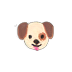
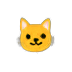
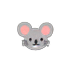
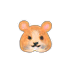
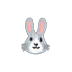
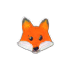
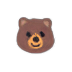
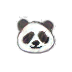

,,,,,,,

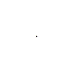
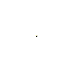
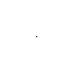
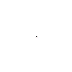
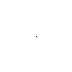
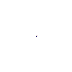
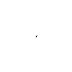
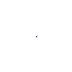

In [55]:
mediapy.show_images(state_to_rgba(state[:, -1]), width=128, height=128)
mediapy.show_videos(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

### Interpolation

#### dog-panda

""

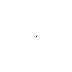

In [56]:
x = jnp.array([0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state = ca(state, x, num_steps=2 * num_steps, all_steps=True)

mediapy.show_video(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

#### fox-panda

""

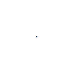

In [59]:
x = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state = ca(state, x, num_steps=2 * num_steps, all_steps=True)

mediapy.show_video(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

#### cat-panda

,,,,,,,

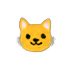
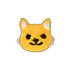
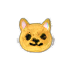
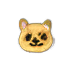
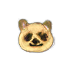
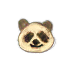
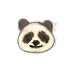
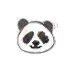

In [60]:
alphas = jnp.linspace(0.0, 1.0, 8)

target_enc_1 = targets_enc[1]
target_enc_2 = targets_enc[7]

target_encs = jnp.array([(1.0 - alpha) * target_enc_1 + alpha * target_enc_2 for alpha in alphas])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=8)(
	nnx.vmap(
		lambda ca, state, target_enc: ca(state, target_enc, num_steps=2 * num_steps),
		in_axes=(state_axes, None, 0),
	)
)(ca, state, target_encs)

mediapy.show_images(state_to_rgba(state), width=128, height=128)